# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle
import random
from random import sample

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(777)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/DCASE_experiments/SSL-Efficientnet/dcase2021_task2/ano_VAE+Centerloss/config.yaml'

In [7]:
torch.cuda.is_available()

True

In [8]:
#ext_data = pd.read_pickle(f'{INPUT_ROOT}/valve_features.pkl')

In [9]:
#train_features = ext_data['train']['features']

In [10]:
#train_features.shape

## training

In [11]:
def random_feature_selection(x, t_d=3776, d=2048):
    idx = torch.tensor(sample(range(0, t_d), d)) # t_d(特徴量)の中からランダムにd個サンプリングする(ぜんぶやると重いから) # わからん
    # 0~t_d idxの中からランダムにd個サンプリングする
    x = np.take(x, idx, 1)
    return x

In [12]:
#ext_data['train'].keys()

In [13]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine_type}_features.pkl')
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    num_classes = 6
    net = Model(in_features, mid_size, latent_size, num_classes)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [14]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

In [15]:
#path='/media/hiroki/HDD1TB/research/dcase2021_task2/output/CenterLossVAE/test_ex22/models/ToyCar_model.pth'
#pretrained_dict = torch.load(path)

In [16]:
#pretrained_dict['center_loss.centers'].shape

In [17]:
#pretrained_dict['center_loss.centers']

In [18]:
# for machine_type in machine_types:
#     run(machine_type)

2021-08-10 20:36:20,032 - 00_train.py - INFO - TARGET MACHINE_TYPE: gearbox
2021-08-10 20:36:20,033 - 00_train.py - INFO - MAKE DATA_LOADER
2021-08-10 20:36:20,869 - 00_train.py - INFO - TRAINING
2021-08-10 20:36:23,957 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 14.69it/s]
2021-08-10 20:36:24,777 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 66.82it/s]
2021-08-10 20:36:24,830 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 91.77it/s]


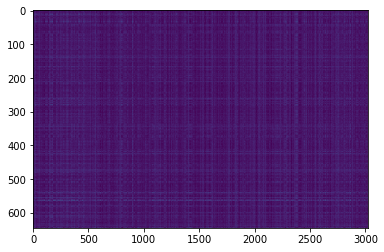

,AUC,pAUC
Source_0,0.477705,0.508900
Source_1,0.431670,0.479189
Source_2,0.638285,0.483855
Target_0,0.607157,0.513889
Target_1,0.326217,0.473684
Target_2,0.586349,0.490602
mean,0.511230,0.491686
h_mean,0.484083,0.491240


2021-08-10 20:36:25,890 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:33151.383138, val_AUC_hmean:0.484083, val_pAUC_hmean:0.491240, best_flag:True
2021-08-10 20:36:25,891 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 27.47it/s]
2021-08-10 20:36:26,330 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 76.77it/s]
2021-08-10 20:36:26,378 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 97.01it/s]


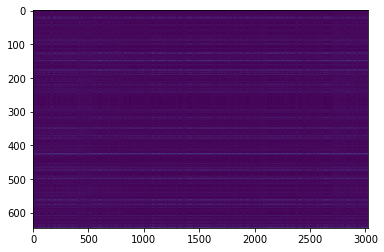

,AUC,pAUC
Source_0,0.488498,0.511857
Source_1,0.481396,0.485145
Source_2,0.632582,0.502712
Target_0,0.636092,0.560794
Target_1,0.360940,0.478467
Target_2,0.635635,0.534879
mean,0.539190,0.512309
h_mean,0.516303,0.510773


2021-08-10 20:36:27,563 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:28107.530924, val_AUC_hmean:0.516303, val_pAUC_hmean:0.510773, best_flag:True
2021-08-10 20:36:27,564 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 28.10it/s]
2021-08-10 20:36:27,993 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 83.26it/s]
2021-08-10 20:36:28,038 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 99.19it/s]


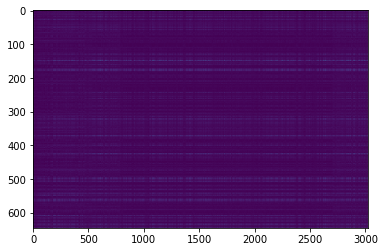

,AUC,pAUC
Source_0,0.507009,0.512371
Source_1,0.483368,0.492816
Source_2,0.628086,0.519027
Target_0,0.712384,0.609527
Target_1,0.418467,0.476482
Target_2,0.645159,0.558688
mean,0.565745,0.528152
h_mean,0.546611,0.524623


2021-08-10 20:36:29,169 - pytorch_modeler.py - INFO - epoch:3/300, train_losses:26526.660482, val_AUC_hmean:0.546611, val_pAUC_hmean:0.524623, best_flag:True
2021-08-10 20:36:29,170 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.15it/s]
2021-08-10 20:36:29,740 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 85.93it/s]
2021-08-10 20:36:29,784 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 96.55it/s]


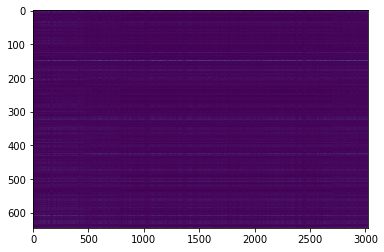

,AUC,pAUC
Source_0,0.518730,0.514684
Source_1,0.498457,0.486589
Source_2,0.632313,0.526160
Target_0,0.733410,0.639884
Target_1,0.442387,0.485597
Target_2,0.654286,0.562865
mean,0.579931,0.535963
h_mean,0.562440,0.531098


2021-08-10 20:36:30,885 - pytorch_modeler.py - INFO - epoch:4/300, train_losses:25485.305990, val_AUC_hmean:0.562440, val_pAUC_hmean:0.531098, best_flag:True
2021-08-10 20:36:30,886 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.10it/s]
2021-08-10 20:36:31,348 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.09it/s]
2021-08-10 20:36:31,406 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 93.66it/s]

In [ ]:
run(machine_types[1])